Мы будем работать с набором данных Reuters — выборкой новостных лент и их тем, публиковавшихся агентством Reuters в 1986 году. Это простой набор данных, широко используемых для классификации текста. Существует 46 разных тем; некоторые темы более широко представлены, некоторые — менее, но для каждой из них в обучающем наборе имеется не менее 10 примеров.

ПОДКЛЮЧЕНИЕ ВСЕХ МОДУЛЕЙ

In [47]:
from keras.datasets import reuters
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np

ЗАГРУЗКА ДАННЫХ

In [48]:


(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10_000)

print(f'number of training examples {len(train_data)}')
print(f'number of testing examples {len(test_data)}')

# каждый пример - список индексов слов
print(train_data[10])

number of training examples 8982
number of testing examples 2246
[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


ДЕКОДИРОВАНИЕ НОВОСТЕЙ ОБРАТНО В ТЕКСТ

In [49]:
def decode_words():
  word_index = reuters.get_word_index()
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
  decoded_words = ' '.join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])
  return decoded_words

decoded_words = decode_words()
print(decoded_words)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


ВЕКТОРИЗАЦИЯ ДАННЫХ

In [50]:
def vectorize(sequences, dimension=10_000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    # в матрице значение из последовательности (sequence) становится единицей, а все остальное - нули
    results[i, sequence] = 1
  return results

x_train = vectorize(train_data)
x_test = vectorize(test_data)


ONE HOT КОДИРОВАНИЕ МЕТОК

In [60]:
def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1
  return results

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

'''
ТО ЖЕ САМОЕ МОЖНО СДЕЛАТЬ ТАК
'''
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)


СОЗДАНИЕ МОДЕЛИ СЕТИ

In [57]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(10000,)))
model.add(Dense(64, activation='relu'))
# в выходном слое будет 46 нейронов
# это значит, что будет возвращаться 46-мерный вектор, где каждый элемент - отдельный выходной класс
# softmax будет возвращать вектор из 46 элементов (от 0 до 1), где каждый элемент будет показывать вероятность
# принадлежности входного образца к каждому из 46 классов
model.add(Dense(46, activation='softmax'))


КОМПИЛЯЦИЯ МОДЕЛИ

In [58]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

СОЗДАДИМ ВЫБОРКУ ИЗ 1000 ПРОВЕРОЧНЫХ ОБРАЗЦОВ

In [61]:
x_check = x_train[:1000]
partial_x_train = x_train[1000:]

y_check = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]


ТРЕНИРОВКА И ПРОВЕРКА ТОЧНОСТИ ВО ВРЕМЯ ТРЕНИРОВКИ

In [63]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_check, y_check))
history = history.history 

Epoch 1/20
13/13 [==============================] - 1s 53ms/step - loss: 0.0814 - accuracy: 0.9615 - val_loss: 0.1158 - val_accuracy: 0.9499
Epoch 2/20
13/13 [==============================] - 1s 45ms/step - loss: 0.0767 - accuracy: 0.9640 - val_loss: 0.1508 - val_accuracy: 0.9530
Epoch 3/20
13/13 [==============================] - 1s 45ms/step - loss: 0.0707 - accuracy: 0.9665 - val_loss: 0.1599 - val_accuracy: 0.9461
Epoch 4/20
13/13 [==============================] - 1s 45ms/step - loss: 0.0732 - accuracy: 0.9671 - val_loss: 0.1768 - val_accuracy: 0.9443
Epoch 5/20
13/13 [==============================] - 1s 45ms/step - loss: 0.0729 - accuracy: 0.9670 - val_loss: 0.1956 - val_accuracy: 0.9436
Epoch 6/20
13/13 [==============================] - 1s 45ms/step - loss: 0.0727 - accuracy: 0.9649 - val_loss: 0.2141 - val_accuracy: 0.9430
Epoch 7/20
13/13 [==============================] - 1s 45ms/step - loss: 0.0697 - accuracy: 0.9662 - val_loss: 0.2207 - val_accuracy: 0.9424
Epoch 8/20
13

СОЗДАНИЕ ГРАФИКОВ ПО ДАННЫМ ТРЕНИРОВКИ

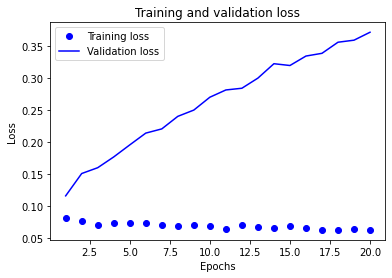

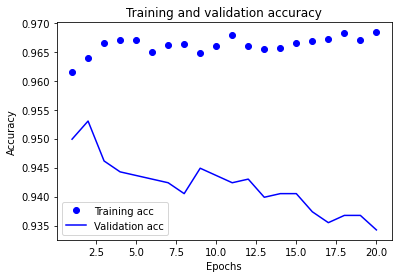

In [64]:
# функция строит графики после тренировки
def draw_graph(history):
    loss_values = history["loss"]
    validation_loss_values = history["val_loss"]

    epochs = range(1, len(history['accuracy']) + 1)

    #               ГРАФИКИ ПОТЕРЬ
    # синими точками рисуется график потерь на этапе обучения
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    # синей линией рисуется график потерь на этапе проверки
    plt.plot(epochs, validation_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # очищаем рисунок
    plt.clf()

    #               ГРАФИКИ ТОЧНОСТИ
    acc_values = history['accuracy']
    validation_acc_values = history['val_accuracy']
    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, validation_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



# рисуем все графики
draw_graph(history)

ПЕРЕОБУЧЕНИЕ ПРОСИХОДИТ НА 9-ОЙ ЭПОХЕ
УМЕНЬШИМ КОЛИЧЕСТВО ЭПОХ ДО 9

In [44]:
history = model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_check, y_check))
history = history.history

Epoch 1/9
16/16 [==============================] - 1s 49ms/step - loss: 0.0679 - accuracy: 0.9594 - val_loss: 1.8041 - val_accuracy: 0.7640
Epoch 2/9
16/16 [==============================] - 1s 46ms/step - loss: 0.0643 - accuracy: 0.9605 - val_loss: 1.7526 - val_accuracy: 0.7680
Epoch 3/9
16/16 [==============================] - 1s 44ms/step - loss: 0.0673 - accuracy: 0.9603 - val_loss: 1.7473 - val_accuracy: 0.7730
Epoch 4/9
16/16 [==============================] - 1s 45ms/step - loss: 0.0658 - accuracy: 0.9599 - val_loss: 1.7999 - val_accuracy: 0.7670
Epoch 5/9
16/16 [==============================] - 1s 47ms/step - loss: 0.0659 - accuracy: 0.9599 - val_loss: 1.8214 - val_accuracy: 0.7600
Epoch 6/9
16/16 [==============================] - 1s 47ms/step - loss: 0.0673 - accuracy: 0.9582 - val_loss: 1.7909 - val_accuracy: 0.7560
Epoch 7/9
16/16 [==============================] - 1s 46ms/step - loss: 0.0659 - accuracy: 0.9570 - val_loss: 1.8399 - val_accuracy: 0.7630
Epoch 8/9
16/16 [===

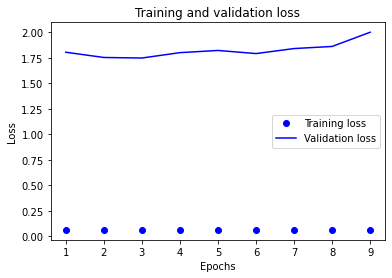

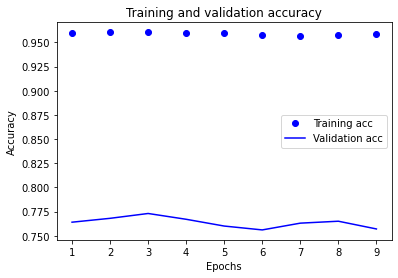

In [45]:
draw_graph(history)

ОЦЕНКА ТОЧНОСТИ НА ТЕСТОВЫХ ДАННЫХ

In [46]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 3ms/step - loss: 2.4071 - accuracy: 0.7431


[2.4070754051208496, 0.7430988550186157]

ПРЕДСКАЗАНИЕ НА НОВЫХ ДАННЫХ

In [65]:
predictions = model.predict(x_test)

# убедимся, что выводятся показания для всех 46 классов
print(predictions[0].shape)

# наиболее вероятный элемент
np.argmax(predictions[0])

(46,)


3